In [334]:
import sys; sys.path.append('..')
import numpy as np
from math import pi, sqrt
import pyzx as zx
%config InlineBackend.figure_format = 'svg'

In [87]:
def Z_to_tensor(arity, phase):
    m = np.zeros([2]*arity, dtype = complex)
    m[(0,)*arity] = 1
    m[(1,)*arity] = np.exp(1j*phase)
    return m

def X_to_tensor(arity, phase):
    m = np.ones(2**arity, dtype = complex)
    for i in range(2**arity):
        if bin(i).count("1")%2 == 0: 
            m[i] += np.exp(1j*phase)
        else:
            m[i] -= np.exp(1j*phase)
    return np.power(np.sqrt(0.5),arity)*m.reshape([2]*arity)

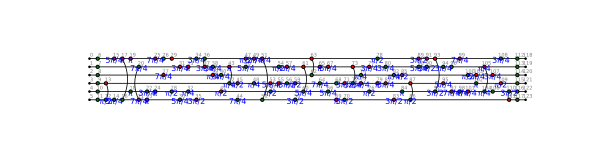

In [458]:
circ = zx.generate.cliffords(6,50,True,True)
#circ.remove_edge((4,5))
#circ.set_phase(4,1)
#zx.simplify.id_simp(circ)
zx.draw(circ,labels=True)

In [397]:
def pop_and_shift(verts, indices):
    res = []
    for v in verts:
        res.append(indices[v].pop())
    for i in sorted(res,reverse=True):
        for w,l in indices.items():
            l2 = []
            for j in l:
                if j>i: l2.append(j-1)
                else: l2.append(j)
            indices[w] = l2
    return res

def tensorfy(g):
    rows = g.rows()
    phases = g.phases()
    types = g.types()
    depth = g.depth()
    verts_row = {}
    for v in g.vertices():
        r = rows[v]
        if r in verts_row: verts_row[r].append(v)
        else: verts_row[r] = [v]
    
    id2 = np.identity(2)
    tensor = np.identity(2)
    qubits = g.qubit_count()
    for i in range(qubits-1): tensor = np.tensordot(tensor,id2,axes=0)
    inputs = sorted(g.inputs,key=g.qubit)
    indices = {}
    for i in inputs:
        indices[i] = [qubits + g.qubit(i)]
    
    for r in sorted(verts_row.keys()):
        if r == 0 or r == depth: continue #inputs and outputs
        for v in sorted(verts_row[r]):
            neigh = list(g.neighbours(v))
            phase = pi*phases[v]
            t = Z_to_tensor(len(neigh),phase) if types[v] == 1 else X_to_tensor(len(neigh),phase)
            nn = list(filter(lambda n: rows[n]<r or (rows[n]==r and n<v), neigh))
            #print(neigh, nn)
            contr = pop_and_shift(nn,indices)
            #print(contr)
            tensor = np.tensordot(tensor,t,axes=(contr,list(range(len(contr)))))
            indices[v] = list(range(len(tensor.shape)-len(neigh)+len(contr), len(tensor.shape)))
            #print(indices)
            #print(tensor)
    
    perm = inputs
    for o in sorted(g.outputs,key=g.qubit):
        n = g.neighbours(o)
        if len(n) != 1: raise ValueError("Weird output")
        n = list(n)[0]
        if len(indices[n]) != 1: raise ValueError("Weird output")
        inputs.append(indices[n][0])
    
    tensor = np.transpose(tensor,perm)
        
    return tensor

In [437]:
def compare_tensors(t1,t2):
    epsilon = 10**-10
    if np.allclose(t1,t2): return True
    for i,a in enumerate(t1.flat):
        if abs(a)>epsilon: 
            if abs(t2.flat[i])<epsilon: return False
            break
    else:
        raise ValueError("Tensor is too close to zero")
    return np.allclose(t1/a,t2/t2.flat[i])
    

In [433]:
sqrt(2)**-65>10**-10

True

spider_simp
22. 12. 9. 6. 4. 1. 
finished in 7 iterations
id_simp
8. 3. 
finished in 3 iterations


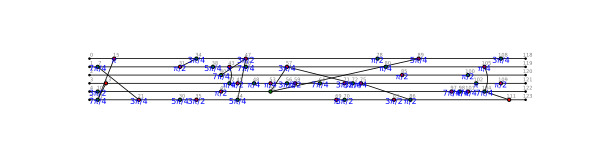

In [459]:
t = tensorfy(circ)
g = circ.copy()

zx.simplify.spider_simp(g)
zx.simplify.id_simp(g)
t2 = tensorfy(g)
zx.draw(g,labels=True)
#np.allclose(t,t2)
#print(t,"\n\n", t2)

In [460]:
compare_tensors(t,t2)

True

In [447]:
list(t.flat)[:20]

[(-5.5517794731374465e-18-0.003906250000000022j),
 (-5.5517794731374465e-18-0.003906250000000021j),
 (-6.3107209938773e-18-0.0039062500000000226j),
 (5.443359255888896e-18+0.0039062500000000226j),
 (-4.5759975179004925e-18-0.003906250000000021j),
 (6.7444018628715014e-18+0.003906250000000022j),
 (-6.310720993877301e-18-0.00390625000000002j),
 (-8.47912533884831e-18-0.003906250000000024j),
 (-0.003906250000000021+9.697417872102024e-18j),
 (0.0039062500000000226-1.0564779610090428e-17j),
 (0.003906250000000019-1.0456359392841877e-17j),
 (0.0039062500000000226-1.1757401999824482e-17j),
 (0.0039062500000000226-9.480577437604923e-18j),
 (0.003906250000000021-9.914258306599125e-18j),
 (-0.003906250000000022+1.1757401999824485e-17j),
 (0.003906250000000022-1.1323721130830284e-17j),
 (-5.5517794731374465e-18-0.003906250000000023j),
 (-5.5517794731374465e-18-0.003906250000000021j),
 (-7.178082731865703e-18-0.0039062500000000226j),
 (4.5759975179004925e-18+0.0039062500000000226j)]

In [248]:
s1 = X_to_tensor(1,0)
s2 = X_to_tensor(1,pi)
s = np.tensordot(s1,s2,axes=0)
s
np.einsum("abcd,cd->ab", tensor, s)

array([[0.+0.j, 2.-0.j],
       [0.+0.j, 0.+0.j]])

In [373]:
#tensor[1,1,0,1]
np.transpose(tensor, [3,2,0,1])
#np.transpose(tensor, [0,3,2,1])

array([[[[0.70710678+0.j, 0.        +0.j],
         [0.        +0.j, 0.70710678+0.j]],

        [[0.70710678+0.j, 0.        +0.j],
         [0.        +0.j, 0.70710678+0.j]]],


       [[[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]],

        [[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]]]])

In [330]:
id2 = Z_to_tensor(2,0)
z = Z_to_tensor(3,0)
print(z)
x = X_to_tensor(3,0)
print(x)
x2 = X_to_tensor(4,0)
a = np.tensordot(id2,z,axes=0)
cnot = np.tensordot(a,x,axes=([1,4],[2,0]))
cnot
#np.transpose(cnot,[0,1,3,2])

[[[1.+0.j 0.+0.j]
  [0.+0.j 0.+0.j]]

 [[0.+0.j 0.+0.j]
  [0.+0.j 1.+0.j]]]
[[[0.70710678+0.j 0.        +0.j]
  [0.        +0.j 0.70710678+0.j]]

 [[0.        +0.j 0.70710678+0.j]
  [0.70710678+0.j 0.        +0.j]]]


array([[[[0.70710678+0.j, 0.        +0.j],
         [0.        +0.j, 0.        +0.j]],

        [[0.        +0.j, 0.        +0.j],
         [0.        +0.j, 0.70710678+0.j]]],


       [[[0.        +0.j, 0.70710678+0.j],
         [0.        +0.j, 0.        +0.j]],

        [[0.        +0.j, 0.        +0.j],
         [0.70710678+0.j, 0.        +0.j]]]])

In [79]:
i = 10
b = [int(j) for j in bin(i)[2:]]
b

[1, 0, 1, 0]

In [118]:
l = [1,2,3]
l.count(2)

1

In [363]:
id2 = [[1,0],[0,1]]
a = [[[1,0],[0,0]],[[0,0],[0,1]]]
b = [[[1,0],[0,1]],[[0,1],[1,0]]]
print(np.einsum("klm,iln->kimn",a,b))
#print(np.tensordot(a,b, axes=(0,0)))
c = np.tensordot(id2, a, axes=0)
cnot = np.tensordot(c,b,axes=([1,3],[1,0]))
#print(cnot)
cnot2 = np.tensordot(id2,np.tensordot(a,b,axes=(1,0)),axes=(1,0))
#print(cnot2)
np.einsum("ij,klm,jln->ikmn",id2,a,b)

[[[[1 0]
   [0 0]]

  [[0 1]
   [0 0]]]


 [[[0 0]
   [0 1]]

  [[0 0]
   [1 0]]]]


array([[[[1, 0],
         [0, 0]],

        [[0, 0],
         [0, 1]]],


       [[[0, 1],
         [0, 0]],

        [[0, 0],
         [1, 0]]]])